In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.collections import PatchCollection
from matplotlib import cm

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy import stats
 
from matplotlib.lines import Line2D
from collections import defaultdict


def load_topic_word_distributions(taxa_prob):
    topic_word_prob_dict = defaultdict(lambda: defaultdict(float))
    topic_sum_dict = defaultdict(float)
    with open(taxa_prob,'r') as f:       
        for _line in f:        
            t, w, p = _line.split('\t')
            topic_word_prob_dict[t][w] = float(p)
            topic_sum_dict[t] += float(p)

    topic_word_probability_dict = defaultdict(lambda: defaultdict(float))
    for t, wp_dict in topic_word_prob_dict.items():
        for i, j in wp_dict.items():
            topic_word_probability_dict[int(t)][i] = j / topic_sum_dict[t]
    return topic_word_probability_dict
  

def get_df(tax_level, thrs):
    list_taxonomies = df_gen0_gen1_mb.columns[2:9]
    temp = df_gen0_gen1_mb.groupby([tax_level]).agg(np.sum)
    X = temp.T
    X = X.loc[:, (X != 0).any(axis=0)]
    X = np.round(X.div(X.sum(axis=1), axis=0)*100000).astype(int)
    pot_names = X.index
    
    if (tax_level != 'Phylum' or tax_level != 'Sequence'):
        abc = df_gen0_gen1_mb[df_gen0_gen1_mb[tax_level].isnull()]
        new_names = []
        if (tax_level == 'Class'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]))
        if (tax_level == 'Order'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]))
        if (tax_level == 'Family'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Order')]))
        if (tax_level == 'Genus'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Order')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Family')]))
        if (tax_level == 'Species'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Order')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Family')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Genus')]))
          
        
        abc[tax_level] = new_names
        abc.index = abc[tax_level]
        del abc[tax_level]
        abc = abc.groupby([tax_level]).agg(np.sum)

        new_names = []
        for i in range(abc.shape[0]):
            new_names.append(abc.index[i] + str('_NA') + str(i+1))
        abc[tax_level] = new_names
        abc.index = abc[tax_level]
        del abc[tax_level]
        abc = abc.T

        X = pd.concat([X, abc], axis = 1)
        X = X.reindex(sorted(X.columns), axis=1)

    
    X = X.T
    excl_all = X[X.astype(bool).sum(axis=1) < thrs].index
    X = X.T

    X.drop(excl_all, axis=1, inplace=True)
    return X

def spearmanr_topic_vs_trait_holmbonf(cur_response, ntopics, alpha, m):
    res_df = pd.concat([pd.DataFrame(sub_data), pd.DataFrame(df_gen0_gen1["SoilSource"]).reset_index(), pd.DataFrame(df_gen0_gen1["Watering"]).reset_index(), pd.DataFrame(df_gen0_gen1["WateringStability"]).reset_index(), pd.DataFrame(df_gen0_gen1[cur_response]).reset_index()], axis = 1)
    del res_df['ID']
    res_df = pd.concat([res_df, pd.DataFrame(df_gen0_gen1["Generation"]).reset_index()], axis = 1)
    res_df = res_df[res_df[cur_response].notna()]
    res_df.columns = topic_names + ['SoilSource', 'Watering', 'WateringStability', cur_response, 'ID', 'Generation']
    store_pval = []
    store_cor = []
    for i in range(ntopics):
        temp = 'Topic ' + str(i+1)
        temp_sp = stats.spearmanr(res_df[cur_response], res_df[temp])
        store_cor.append(temp_sp[0])
        store_pval.append(temp_sp[1])
    return store_cor, store_pval


In [2]:
#read data from GEN 0-1
df_gen0_mb = pd.read_csv("data/MASTER_NDGen0_SoilBacteria.csv")
df_gen1_mb = pd.read_csv("data/MASTER_NDGen1_SoilBacteria.csv")
print('gen0 #mb ', df_gen0_mb.shape, " gen1 #mb ", df_gen1_mb.shape)

df_gen0_gen1_mb = pd.merge(df_gen0_mb, df_gen1_mb, on=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence'], how='outer')
df = df_gen0_gen1_mb

# how many unidentified
print("Species: ", (len(df)-df.iloc[:,7].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,7].count())/len(df)*100, "% NAs")
print("Genus: ", (len(df)-df.iloc[:,6].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,6].count())/len(df)*100, "% NAs")
print("Family: ", (len(df)-df.iloc[:,5].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,5].count())/len(df)*100, "% NAs")
print("Order: ", (len(df)-df.iloc[:,4].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,4].count())/len(df)*100, "% NAs")
print("Class: ", (len(df)-df.iloc[:,3].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,3].count())/len(df)*100, "% NAs")
print("Phylum: ", (len(df)-df.iloc[:,2].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,2].count())/len(df)*100, "% NAs")
print("Kingdom: ", (len(df)-df.iloc[:,1].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,1].count())/len(df)*100, "% NAs")
print("DNA: ", (len(df)-df.iloc[:,0].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,0].count())/len(df)*100, "% NAs")

print('\n')
print("Species: ", df.iloc[:,7].nunique(), "unique names out of", df.iloc[:,7].count())
print("Genus: ", df.iloc[:,6].nunique(), "unique names out of", df.iloc[:,6].count())
print("Family: ", df.iloc[:,5].nunique(), "unique names out of", df.iloc[:,5].count())
print("Order: ", df.iloc[:,4].nunique(), "unique names out of", df.iloc[:,4].count())
print("Class: ", df.iloc[:,3].nunique(), "unique names out of", df.iloc[:,3].count())
print("Phylum: ", df.iloc[:,2].nunique(), "unique names out of", df.iloc[:,2].count())
print("Kingdom: ", df.iloc[:,1].nunique(), "unique names out of", df.iloc[:,1].count())
print("DNA: ", df.iloc[:,0].nunique(), "unique names out of", df.iloc[:,0].count())

#aggregation
df_gen0_gen1_mb = pd.merge(df_gen0_mb, df_gen1_mb, on=['ASV_number', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence'], how='outer')
df_gen0_gen1_mb = df_gen0_gen1_mb.groupby(['Phylum']).agg(np.sum)
df_gen0_gen1_mb = df_gen0_gen1_mb.T
df_gen0_gen1_mb_full = df_gen0_gen1_mb.copy()
df_gen0_gen1_mb = df_gen0_gen1_mb.drop(['N00030', 'N00050'])
#gen0-1 source, treatment
df_gen0_id = pd.ExcelFile("data/MASTER_NDGen0_CornID.xlsx")
df_gen0_id = df_gen0_id.parse('ID', header=0, index_col = 0)
df_gen0_id = pd.DataFrame(df_gen0_id)

df_gen1_id = pd.ExcelFile("data/MASTER_NDGen1_CornID.xlsx")
df_gen1_id = df_gen1_id.parse('ID', header=0, index_col = 0)
df_gen1_id = pd.DataFrame(df_gen1_id)
df_gen0_gen1_id = pd.concat([df_gen0_id, df_gen1_id], axis=0)

df_gen0_gen1 = pd.merge(df_gen0_gen1_mb, df_gen0_gen1_id, right_on='ID', left_index=True)

#create treatment_stable column; stable(same watering as in gen0), switched(switched watering)
#Treatment_Source isn't avail for gen0
df_gen0_gen1['Treatment_Source'].fillna('None', inplace=True) 
df_gen0_gen1['Treatment_Stable'] = np.nan
source_index = df_gen0_gen1.columns.get_loc('Treatment_Source')
stable_index = df_gen0_gen1.columns.get_loc('Treatment_Stable')
water_index = df_gen0_gen1.columns.get_loc('Treatment')

idx_water_stability_none = []
idx_water_stability_stable = []
idx_water_stability_switched = []
for i in range(df_gen0_gen1.shape[0]):
    if (df_gen0_gen1.iloc[i, source_index] == 'None'):
        idx_water_stability_none.append(i)
    elif (df_gen0_gen1.iloc[i, source_index] != 'None' and df_gen0_gen1.iloc[i, source_index] == df_gen0_gen1.iloc[i, water_index]):
        idx_water_stability_stable.append(i)
    else:
        idx_water_stability_switched.append(i)

df_gen0_gen1.iloc[idx_water_stability_none, stable_index] = 'None'
df_gen0_gen1.iloc[idx_water_stability_stable, stable_index] = 'Stable'
df_gen0_gen1.iloc[idx_water_stability_switched, stable_index] = 'Switched'


df_gen0_gen1.columns = df_gen0_gen1.columns.str.replace('Microbiome_Parent', 'SoilSource')
df_gen0_gen1.columns = df_gen0_gen1.columns.str.replace('Treatment_Stable', 'WateringStability')
df_gen0_gen1.columns = df_gen0_gen1.columns.str.replace('Treatment', 'Watering')
gen_index = df_gen0_gen1.columns.get_loc('Generation')
source_index = df_gen0_gen1.columns.get_loc('SoilSource')
stability_index = df_gen0_gen1.columns.get_loc('WateringStability')
water_index = df_gen0_gen1.columns.get_loc('Watering')


df_gen0_gen1.iloc[:, source_index] = pd.Categorical(df_gen0_gen1.iloc[:, source_index])
df_gen0_gen1.iloc[:, source_index] = df_gen0_gen1.iloc[:, source_index].cat.codes
df_gen0_gen1.iloc[:, water_index] = pd.Categorical(df_gen0_gen1.iloc[:, water_index])
df_gen0_gen1.iloc[:, water_index] = df_gen0_gen1.iloc[:, water_index].cat.codes
df_gen0_gen1.iloc[:, stability_index] = pd.Categorical(df_gen0_gen1.iloc[:, stability_index])
df_gen0_gen1.iloc[:, stability_index] = df_gen0_gen1.iloc[:, stability_index].cat.codes


df_gen0_gen1_mb = pd.merge(df_gen0_mb, df_gen1_mb, on=['ASV_number', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence'], how='outer')
df_gen0_gen1_mb_full = df_gen0_gen1_mb.copy()
df_gen0_gen1_mb = df_gen0_gen1_mb.drop(['N00030', 'N00050'], axis=1)

#gen0-1 physical 
df_gen0_phys = pd.ExcelFile("data/MASTER_NDGen0_PlantPhys.xlsx")
df_gen0_phys = df_gen0_phys.parse('Data', header=0, index_col = 0)
df_gen0_phys = pd.DataFrame(df_gen0_phys)

df_gen1_phys = pd.ExcelFile("data/MASTER_NDGen1_PlantPhys.xlsx")
df_gen1_phys = df_gen1_phys.parse('Data', header=0, index_col = 0)
df_gen1_phys = pd.DataFrame(df_gen1_phys)
df_gen0_gen1_phys = pd.concat([df_gen0_phys, df_gen1_phys], axis=0)


del df_gen0_gen1_phys['SCP_End']
del df_gen0_gen1_phys['GasLeaf']
del df_gen0_gen1_phys['LiCor']
del df_gen0_gen1_phys['GasEx_Date']
del df_gen0_gen1_phys['Gs_rate']
del df_gen0_gen1_phys['VWC_rate']
del df_gen0_gen1_phys['Gs.VWC_slope']
del df_gen0_gen1_phys['AboveDry_g']

df_gen0_gen1 = pd.merge(df_gen0_gen1, df_gen0_gen1_phys, right_on='ID', left_index=True)

X_phylum = get_df('Phylum', 4)
df_gen0_gen1['LMA'] = df_gen0_gen1['LMA'].fillna(df_gen0_gen1['LMA']. mean())

selected_mb_indicies = []
for i in range(X_phylum.shape[1]):
    if X_phylum.iloc[:, i][X_phylum.iloc[:, i] != 0].count() >= 0*X_phylum.shape[0]:
        selected_mb_indicies.append(i)

norm_by_pot_X_phylum = X_phylum.div(X_phylum.sum(axis=1), axis = 0)
response_list = ['Amax', 'Cond',
       'WUEi', 'Height_cm', 'Stem_Diam',
       'RootDry_g', 'LWC', 'LMA', 'DroughtTime']

print("Spearman correlations between topic abundances and ", response_list)
#print("shapes: ", norm_by_pot_X_phylum.shape, df_gen0_gen1.shape)

def spearmanr_individual_vs_trait_holmbonf_ph(cur_response, alpha, m):
    store_pval = []
    store_cor = []
    for i in range(len(selected_mb_indicies)):
        temp_sp = stats.spearmanr(norm_by_pot_X_phylum.iloc[:, selected_mb_indicies[i]], df_gen0_gen1[cur_response])
        store_cor.append(temp_sp[0])
        store_pval.append(temp_sp[1])
    return store_cor, store_pval

store_cor = []
store_pval = []
for i in response_list:
    store_cor.append(spearmanr_individual_vs_trait_holmbonf_ph(i, 0.05, len(selected_mb_indicies)*len(response_list))[0])
    store_pval.append(spearmanr_individual_vs_trait_holmbonf_ph(i, 0.05, len(selected_mb_indicies)*len(response_list))[1])

print("-------------------------")
indiv_list = norm_by_pot_X_phylum.iloc[:, selected_mb_indicies].columns
store_pval = [item for sublist in store_pval for item in sublist]
store_cor = [item for sublist in store_cor for item in sublist]
store_names = [item for item in response_list for i in range(len(selected_mb_indicies))]
store_indivs = list(indiv_list)*len(response_list)
df_p = pd.DataFrame(
    {'individual': store_indivs,
     'response': store_names,   
     'correlation': store_cor,
     'p-value': store_pval
    })
cor_alpha = len(df_p.sort_values("p-value"))
alpha = 0.05
df_p = df_p.sort_values("p-value", ascending=True).reset_index()
save_ix = []
for i in range(len(df_p)):
    if (df_p['p-value'][i] <= alpha/cor_alpha):
        cor_alpha -= 1
        save_ix.append(df_p.index[i])

df_p = df_p.iloc[save_ix, 1:5]
print(df_p.to_latex(index=False))  
df_p.iloc[:, 0].value_counts()
df_p.iloc[:, 0].nunique()
df_gen0_gen1['LMA'] = df_gen0_gen1['LMA'].fillna(df_gen0_gen1['LMA']. mean())



X_seq = get_df('Sequence', 0)
df_norm = X_seq
col_names = []
for i in range(len(df_norm.columns)):
    col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,])  + "__" +
    str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" + 
    str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) ))
nontruncated_col_names = col_names
trim = 254
col_names = [z[:-trim] for z in col_names]
df_norm.columns = col_names
df_norm = df_norm.T
    
    
selected_mb_indicies = []
for i in range(X_seq.shape[1]):
    if X_seq.iloc[:, i][X_seq.iloc[:, i] != 0].count() >= 0*X_seq.shape[0]:
        selected_mb_indicies.append(i)

norm_by_pot_X_seq = X_seq.div(X_seq.sum(axis=1), axis = 0)
response_list = ['Amax', 'Cond',
       'WUEi', 'Height_cm', 'Stem_Diam',
       'RootDry_g', 'LWC', 'LMA', 'DroughtTime']



def spearmanr_individual_vs_trait_holmbonf_sq(cur_response, alpha, m):
    store_pval = []
    store_cor = []
    for i in range(len(selected_mb_indicies)):
        temp_sp = stats.spearmanr(norm_by_pot_X_seq.iloc[:, selected_mb_indicies[i]], df_gen0_gen1[cur_response])
        store_cor.append(temp_sp[0])
        store_pval.append(temp_sp[1])
    return store_cor, store_pval

store_cor = []
store_pval = []
for i in response_list:
    store_cor.append(spearmanr_individual_vs_trait_holmbonf_sq(i, 0.05, len(selected_mb_indicies)*len(response_list))[0])
    store_pval.append(spearmanr_individual_vs_trait_holmbonf_sq(i, 0.05, len(selected_mb_indicies)*len(response_list))[1])

print("-------------------------")
indiv_list = norm_by_pot_X_seq.iloc[:, selected_mb_indicies].columns
store_pval = [item for sublist in store_pval for item in sublist]
store_cor = [item for sublist in store_cor for item in sublist]
store_names = [item for item in response_list for i in range(len(selected_mb_indicies))]
store_indivs = list(indiv_list)*len(response_list)
df_p = pd.DataFrame(
    {'individual': store_indivs,
     'response': store_names,   
     'correlation': store_cor,
     'p-value': store_pval
    })
cor_alpha = len(df_p.sort_values("p-value"))
alpha = 0.05
df_p = df_p.sort_values("p-value", ascending=True).reset_index()
save_ix = []
for i in range(len(df_p)):
    if (df_p['p-value'][i] <= alpha/cor_alpha):
        cor_alpha -= 1
        save_ix.append(df_p.index[i])


df_p = df_p.iloc[save_ix, 1:5]
#print(df_p.to_latex(index=False))  
print("ASVs")
df_p
#df_p.iloc[:, 0].value_counts()
#df_p.iloc[:, 0].nunique()
#df_p.sort_values(by = ['correlation', 'individual'], axis=0, ascending=[True, True], inplace=False,
#               kind='quicksort', na_position='first', ignore_index=True, key=None)[0:30]

#rename ASVs
X_seq = get_df('Sequence', 0)
df_norm = X_seq
col_names = []
for i in range(len(df_norm.columns)):
    col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,])  + "__" +
    str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" + 
    str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) ))
nontruncated_col_names = col_names
trim = 254
col_names = [z[:-trim] for z in col_names]
df_norm.columns = col_names
df_norm = df_norm.T
X_seq = df_norm.T
X_seq.head()

gen0 #mb  (9707, 66)  gen1 #mb  (9707, 73)
Species:  9033 NAs out of 9707   93.05655712372514 % NAs
Genus:  4966 NAs out of 9707   51.158957453384154 % NAs
Family:  2090 NAs out of 9707   21.530854022870095 % NAs
Order:  872 NAs out of 9707   8.983207994230966 % NAs
Class:  169 NAs out of 9707   1.7410116410837542 % NAs
Phylum:  0 NAs out of 9707   0.0 % NAs
Kingdom:  0 NAs out of 9707   0.0 % NAs
DNA:  0 NAs out of 9707   0.0 % NAs


Species:  424 unique names out of 674
Genus:  536 unique names out of 4741
Family:  275 unique names out of 7617
Order:  200 unique names out of 8835
Class:  95 unique names out of 9538
Phylum:  38 unique names out of 9707
Kingdom:  2 unique names out of 9707
DNA:  9707 unique names out of 9707
Spearman correlations between topic abundances and  ['Amax', 'Cond', 'WUEi', 'Height_cm', 'Stem_Diam', 'RootDry_g', 'LWC', 'LMA', 'DroughtTime']
-------------------------
\begin{tabular}{llrr}
\toprule
       individual &    response &  correlation &      p-value \

Thermoplasmatota     3
Crenarchaeota        2
Gemmatimonadota      2
Verrucomicrobiota    2
Bdellovibrionota     2
Actinobacteriota     1
WPS-2                1
Elusimicrobiota      1
Sumerlaeota          1
Dependentiae         1
Deinococcota         1
Name: individual, dtype: int64

11

-------------------------
ASVs


individual   response  \
0    Bacteroidota__Bacteroidia__Sphingobacteriales_...  Height_cm   
1    Proteobacteria__Gammaproteobacteria__Burkholde...  Height_cm   
2    Proteobacteria__Gammaproteobacteria__Cellvibri...  Height_cm   
3    Planctomycetota__Planctomycetes__Gemmatales__G...  Height_cm   
4    Bacteroidota__Bacteroidia__Sphingobacteriales_...  Height_cm   
..                                                 ...        ...   
207  Proteobacteria__Alphaproteobacteria__Sphingomo...  Stem_Diam   
208  Proteobacteria__Gammaproteobacteria__Salinisph...  Height_cm   
209  Proteobacteria__Alphaproteobacteria__Acetobact...  Height_cm   
210             Bacteroidota__nan__nan__nan__nan__nan_        LMA   
211  Actinobacteriota__Actinobacteria__Pseudonocard...  RootDry_g   

     correlation       p-value  
0       0.767264  2.559071e-24  
1       0.735327  1.697101e-21  
2       0.729798  4.754105e-21  
3       0.714902  6.751725e-20  
4       0.708021  2.173802e-19  
..           ...           ...  
207    -0.426705  1.304234e-06  
208    -0.426522  1.319435e-06  
209     0.426168  1.349245e-06  
210    -0.425907  1.371670e-06  
211    -0.425575  1.400612e-06  

[212 rows x 4 columns]

Bacteroidota__Bacteroidia__Cytophagales__Microscillaceae__nan__nan  \
N00001                                                  0                    
N00010                                                  0                    
N00011                                                  0                    
N00012                                                  0                    
N00013                                                  0                    

        Bacteroidota__Bacteroidia__Cytophagales__Microscillaceae__Ohtaekwangia__nan  \
N00001                                                  0                             
N00010                                                  0                             
N00011                                                  0                             
N00012                                                  0                             
N00013                                                  0                             

        Actinobacteriota__Actinobacteria__Propionibacteriales__Propionibacteriaceae__Cutibacterium__acnes/avidum_  \
N00001                                                  0                                                           
N00010                                                  0                                                           
N00011                                                  0                                                           
N00012                                                  0                                                           
N00013                                                  0                                                           

        Actinobacteriota__Actinobacteria__Micrococcales__Intrasporangiaceae__Aquipuribacter__nan_  \
N00001                                                  0                                           
N00010                                                  0                                           
N00011                                                  0                                           
N00012                                                  0                                           
N00013                                                  0                                           

        Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_  \
N00001                                                  0                                          
N00010                                                  0                                          
N00011                                                  0                                          
N00012                                                  0                                          
N00013                                                  0                                          

        Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_  \
N00001                                                  0                                          
N00010                                                  0                                          
N00011                                                  0                                          
N00012                                                  0                                          
N00013                                                  0                                          

        Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_  \
N00001                                                  0                                          
N00010                                                  0                                          
N00011                                                  0                                          
N00012                                                  0                                          
N000

In [3]:
#specify tax_level below
tax_level = 'Order'#'Phylum', 'Class', 'Order', 'Family', 'Sequence'
    
if (tax_level == 'Phylum'):
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 6
    thrs = 4
elif (tax_level == 'Class'):        
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 8
    thrs = 4        
elif (tax_level == 'Order'):        
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 10
    thrs = 4
elif (tax_level == 'Family'):
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 20
    thrs = 4  
elif (tax_level == 'Sequence'):
    folder_main_name = 'nonde_data/'
    folder_name = '_original_res10k'
    path = '../gitlab/data/5cv_all_sequence'
    NTOPICS = 25
    thrs = 0        

    

X = get_df(tax_level, thrs)
print("X.shape: ", X.shape)
df = X.iloc[:, 0:].div(X.iloc[:, 0:].sum(axis=1), axis=0)
df = pd.DataFrame(np.mean(df.iloc[:, :]))
df = df.sort_values(0, ascending = False)
df = df.T

# uncomment to produce files for MALLET
# for row_id in range(X.shape[0]):
#     ts = []
#     for col_id in range(X.shape[1]):
#         ts = str(ts) + (X.iloc[row_id, :].index[col_id] + ' ') * X.iloc[row_id, col_id]

#     textfile = open(str(str('../gitlab/data/nonde_data/sequence_less2/') + str(X.index[row_id]) + str('.txt')), 'w')
#     textfile.write(ts[2:])
#     textfile.close()
    
    
topic_names = []
for i in range(NTOPICS):
    topic_names.append('Topic ' + str(i+1))
    
list_taxa = X.columns
df_taxa = pd.DataFrame(list_taxa).T
df_taxa.columns = df_taxa.iloc[0, :]
twd = load_topic_word_distributions(path + '/topic-word-weights_'+str(NTOPICS)+'.dat')

temp = pd.DataFrame([twd[0]])
df_al = pd.merge(df_taxa.T, temp.T, left_index=True, right_index=True, how='inner').fillna(0)
del df_al[tax_level]
df_al = df_al.T
df_al.reset_index(inplace=True)
del df_al['index']
df_fin = df_al
for k in range(1, len(twd)):
    temp = pd.DataFrame([twd[k]])
    df_al = pd.merge(df_taxa.T, temp.T, left_index=True, right_index=True, how='inner').fillna(0)
    del df_al[tax_level]
    df_al = df_al.T
    df_al.reset_index(inplace=True)
    del df_al['index']
    df_fin = pd.merge(df_fin.T, df_al.T, left_index=True, right_index=True, how='inner').fillna(0) 
    df_fin = df_fin.T
    
df_norm = df_fin.T
df_norm.columns = topic_names
g = df_norm
aa = X.iloc[:, 0:].div(X.iloc[:, 0:].sum(axis=1), axis=0)
df = pd.DataFrame(np.mean(aa.iloc[:, :]))
df.index = np.sort(list_taxa)
s = g.T
df = df.T
s = s / df.loc[0]
s = s.T
s = s.div(s.sum())

if tax_level == 'Sequence':
    df_norm = df_norm.T
    col_names = []
    for i in range(len(df_norm.columns)):
        col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,])  + "__" +
        str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" + 
        str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) ))
    nontruncated_col_names = col_names
    trim = 254 #change # of chars to trim ASV names
    col_names = [z[:-trim] for z in col_names]
    df_norm.columns = col_names
    df_norm = df_norm.T

    s = s.T
    col_names = []
    for i in range(len(s.columns)):
        col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,])  + "__" +
        str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" + 
        str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) ))
    nontruncated_col_names = col_names
    trim = 254
    col_names = [z[:-trim] for z in col_names]
    s.columns = col_names
    s = s.T
    

if tax_level == 'Class':
    ylabels = df_norm.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Class'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    df_norm.index = ylabels_ext
    ylabels = s.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Class'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    s.index = ylabels_ext

if tax_level == 'Order':
    ylabels = df_norm.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    df_norm.index = ylabels_ext
    ylabels = s.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    s.index = ylabels_ext
    
if tax_level == 'Family':
    ylabels = df_norm.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" +
                               str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    df_norm.index = ylabels_ext
    ylabels = s.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" +
                               str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    s.index = ylabels_ext
    
twd = load_topic_word_distributions(path + '/topic-word-weights_'+str(NTOPICS)+'.dat')
temp = pd.DataFrame([twd[0]])
for i in range(1, len(twd)):
    temp = pd.concat([temp, pd.DataFrame([twd[i]])])
temp = temp.reset_index()
del temp['index']
mtx_topics = pd.DataFrame(cosine_similarity(temp))
matrix = np.triu(mtx_topics)

print("The # topic pairs that have cosine similarity >= 0.9 is", matrix[matrix >= 0.90].shape[0] - NTOPICS)
for i in range(NTOPICS-1):
    for j in range(i+1, NTOPICS):
        if (matrix[i][j] > 0.8):
            print(i+1, j+1, matrix[i][j])

X.shape:  (119, 152)
The # topic pairs that have cosine similarity >= 0.9 is 0


(152, 10)

[[<matplotlib.axis.XTick at 0x7facd8eebd60>,
 [Text(0, 0, 'Topic 1'),
  Text(1, 0, 'Topic 2'),
  Text(2, 0, 'Topic 3'),
  Text(3, 0, 'Topic 4'),
  Text(4, 0, 'Topic 5'),
  Text(5, 0, 'Topic 6'),
  Text(6, 0, 'Topic 7'),
  Text(7, 0, 'Topic 8'),
  Text(8, 0, 'Topic 9'),
  Text(9, 0, 'Topic 10')],
 [Text(0, 0, 'Abditibacteriota_Abditibacteria_Abditibacteriales'),
  Text(0, 1, 'Acidobacteriota_Acidobacteriae_Acidobacteriae_or'),
  Text(0, 2, 'Acidobacteriota_Acidobacteriae_Acidobacteriales'),
  Text(0, 3, 'Acidobacteriota_Acidobacteriae_Bryobacterales'),
  Text(0, 4, 'Acidobacteriota_Acidobacteriae_Solibacterales'),
  Text(0, 5, 'Acidobacteriota_Blastocatellia_24-Nov'),
  Text(0, 6, 'Acidobacteriota_Blastocatellia_Blastocatellales'),
  Text(0, 7, 'Acidobacteriota_Blastocatellia_DS-100'),
  Text(0, 8, 'Acidobacteriota_Blastocatellia_Pyrinomonadales'),
  Text(0, 9, 'Acidobacteriota_Holophagae_Subgroup_7'),
  Text(0, 10, 'Acidobacteriota_Thermoanaerobaculia_Thermoanaerobaculales'),
  Text(0,

[Text(0, 0, 'Topic 1'),
 Text(1, 0, 'Topic 2'),
 Text(2, 0, 'Topic 3'),
 Text(3, 0, 'Topic 4'),
 Text(4, 0, 'Topic 5'),
 Text(5, 0, 'Topic 6'),
 Text(6, 0, 'Topic 7'),
 Text(7, 0, 'Topic 8'),
 Text(8, 0, 'Topic 9'),
 Text(9, 0, 'Topic 10')]

[Text(0, 0, 'Abditibacteriota_Abditibacteria_Abditibacteriales'),
 Text(0, 1, 'Acidobacteriota_Acidobacteriae_Acidobacteriae_or'),
 Text(0, 2, 'Acidobacteriota_Acidobacteriae_Acidobacteriales'),
 Text(0, 3, 'Acidobacteriota_Acidobacteriae_Bryobacterales'),
 Text(0, 4, 'Acidobacteriota_Acidobacteriae_Solibacterales'),
 Text(0, 5, 'Acidobacteriota_Blastocatellia_24-Nov'),
 Text(0, 6, 'Acidobacteriota_Blastocatellia_Blastocatellales'),
 Text(0, 7, 'Acidobacteriota_Blastocatellia_DS-100'),
 Text(0, 8, 'Acidobacteriota_Blastocatellia_Pyrinomonadales'),
 Text(0, 9, 'Acidobacteriota_Holophagae_Subgroup_7'),
 Text(0, 10, 'Acidobacteriota_Thermoanaerobaculia_Thermoanaerobaculales'),
 Text(0, 11, 'Acidobacteriota_Vicinamibacteria_Subgroup_17'),
 Text(0, 12, 'Acidobacteriota_Vicinamibacteria_Vicinamibacterales'),
 Text(0, 13, 'Actinobacteriota_Acidimicrobiia_IMCC26256'),
 Text(0, 14, 'Actinobacteriota_Acidimicrobiia_Microtrichales'),
 Text(0, 15, 'Actinobacteriota_Acidimicrobiia_NA11'),
 Text(0, 

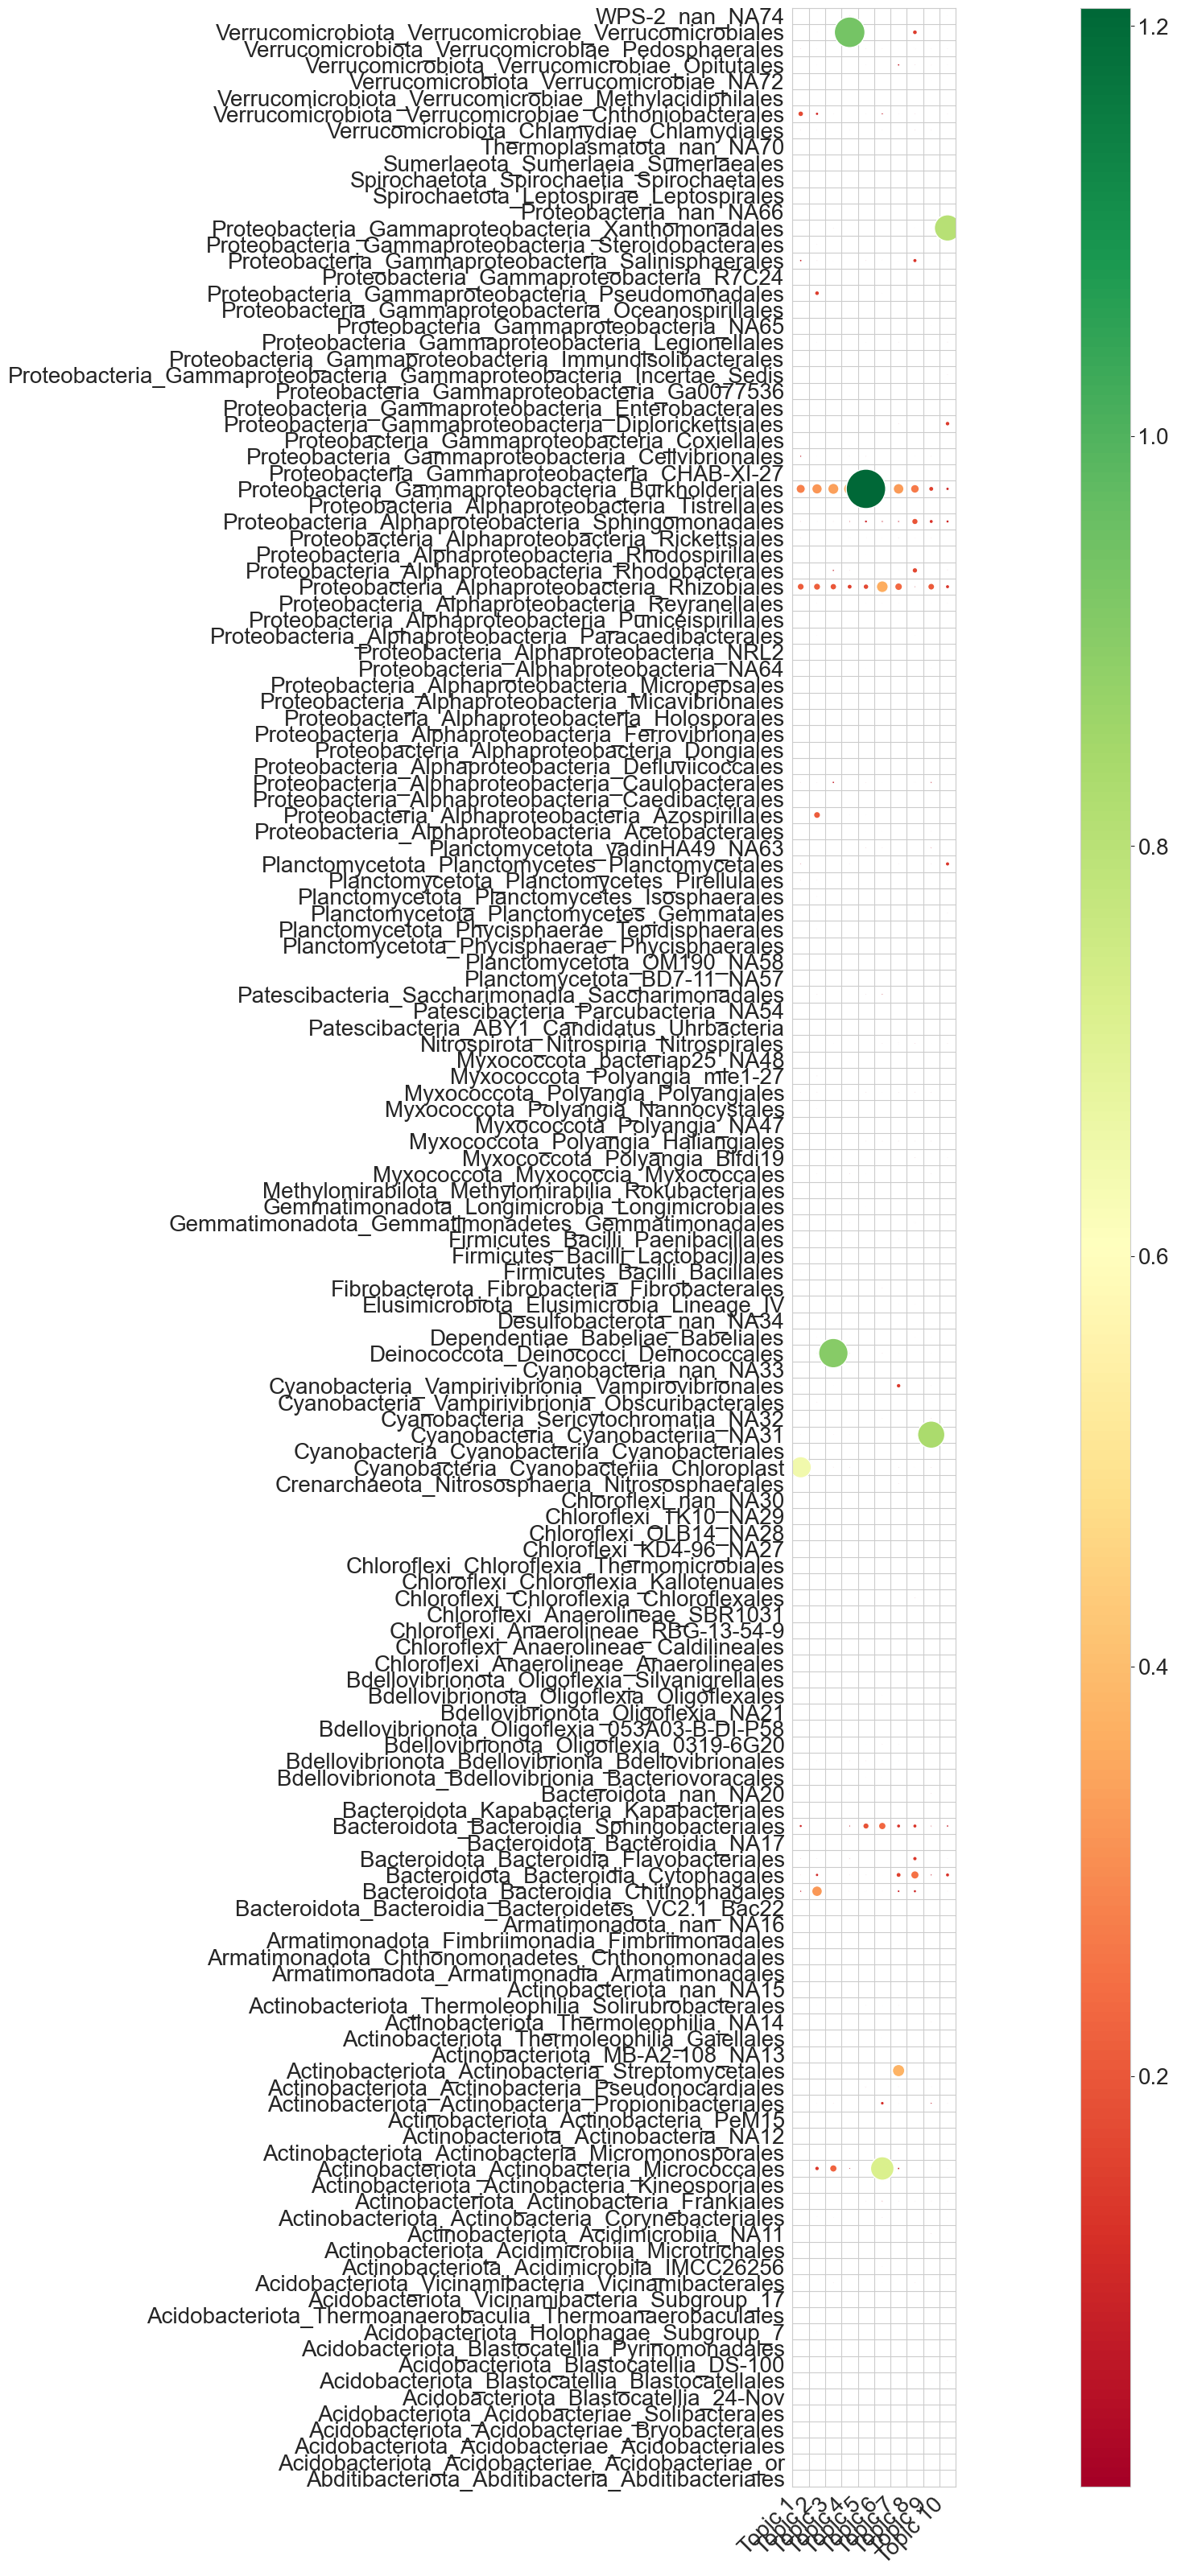

In [5]:
#bubble plots
if tax_level == "Sequence":
    g_thrs = 0.025#0.01#.025
    g = df_norm
    g = g[g >= g_thrs].fillna(0)
    g = g[(g.T != 0).any()]
    g = g.sort_index()
    g.shape
    #seqwater 
    g = g[['Topic 9', 'Topic 13', 'Topic 17', 'Topic 5', 'Topic 18', 'Topic 12', 'Topic 1', 'Topic 3', 'Topic 20', 'Topic 24', 'Topic 11', 'Topic 10', 'Topic 25', 'Topic 8', 'Topic 15', 'Topic 7', 'Topic 14', 'Topic 22', 'Topic 21', 'Topic 16', 'Topic 19', 'Topic 23', 'Topic 2', 'Topic 6', 'Topic 4']]
    #soil g = g[['Topic 1', 'Topic 4', 'Topic 15', 'Topic 24', 'Topic 3', 'Topic 12', 'Topic 19', 'Topic 9', 'Topic 14', 'Topic 20', 'Topic 6', 'Topic 13', 'Topic 21', 'Topic 11', 'Topic 17', 'Topic 23', 'Topic 7', 'Topic 18', 'Topic 5', 'Topic 2', 'Topic 8', 'Topic 16', 'Topic 10', 'Topic 22', 'Topic 25']]
    #seqstability g = g[['Topic 9', 'Topic 14', 'Topic 7', 'Topic 13', 'Topic 4', 'Topic 3', 'Topic 12', 'Topic 22', 'Topic 21', 'Topic 11', 'Topic 6', 'Topic 8', 'Topic 15', 'Topic 18', 'Topic 23', 'Topic 24', 'Topic 19', 'Topic 1', 'Topic 2', 'Topic 16', 'Topic 25', 'Topic 5', 'Topic 10', 'Topic 17', 'Topic 20']]

    ylabels = g.index
    xlabels = g.columns
    N = len(ylabels)
    M = len(xlabels)

    x, y = np.meshgrid(np.arange(M), np.arange(N))
    c = np.random.rand(N, M)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(40,40))

    R = g*4
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(np.array(R).flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=np.array(R).flatten(), cmap="RdYlGn")
    ax.add_collection(col)

    y_order = sorted(ylabels)
    ax.set(xticks=np.arange(M), yticks=np.arange(N),
           xticklabels=xlabels, yticklabels=y_order)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.set_xticklabels(xlabels, rotation = 45, ha="right", fontsize=30)

    colors = [['red']*11, ['black']*4, ['blue']*10]
    colors = [item for sublist in colors for item in sublist]
    colors
    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)


    ax.set_yticklabels(y_order, fontsize=35)
    ax.grid(which='both')
    ax.set_aspect("equal", "box")
    cbar = plt.colorbar(col, aspect=50)
    cbar.ax.tick_params(labelsize=35) 

    legend_elements2 = [Line2D([0], [0], color = 'red', label='Half-water',
                              markerfacecolor='black', markersize=30),
                       Line2D([0], [0], color = 'blue', label='Full-water',
                              markerfacecolor='black', markersize=30),
                       Line2D([0], [0], color = 'black', label='No association',
                              markerfacecolor='black', markersize=30)]

    leg2 = ax.legend(handles=legend_elements2, loc = 'upper right', fontsize = 33, title_fontsize = 35, bbox_to_anchor = (1.7, 1), ncol = 1, title = 'Topic Water Associations')
    ax.add_artist(leg2)
    #plt.savefig('./upd_images/plot_water_' + str(tax_level) + '.eps', format='eps', bbox_inches='tight')
    plt.show();
else:
    g_thrs = 0 # change this threshold for plotting, put 0 for phylum and class; 0.025 for Sequence (ASV)
    g = df_norm
    g = g[g >= g_thrs].fillna(0)
    g = g[(g.T != 0).any()]
    g = g.sort_index()
    g.shape
    #family level, order topics g = g[['Topic 8', 'Topic 3', 'Topic 1', 'Topic 12', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 19', 'Topic 15', 'Topic 5', 'Topic 6', 'Topic 16', 'Topic 4', 'Topic 2', 'Topic 17', 'Topic 7', 'Topic 20', 'Topic 18', 'Topic 13', 'Topic 14']]
    #ASV plot by water g = g[['Topic 9', 'Topic 13', 'Topic 17', 'Topic 5', 'Topic 18', 'Topic 12', 'Topic 1', 'Topic 3', 'Topic 20', 'Topic 24', 'Topic 11', 'Topic 10', 'Topic 25', 'Topic 8', 'Topic 15', 'Topic 7', 'Topic 14', 'Topic 22', 'Topic 21', 'Topic 16', 'Topic 19', 'Topic 23', 'Topic 2', 'Topic 6', 'Topic 4']]
    #ASV plot by soil g = g[['Topic 1', 'Topic 4', 'Topic 15', 'Topic 24', 'Topic 3', 'Topic 12', 'Topic 19', 'Topic 9', 'Topic 14', 'Topic 20', 'Topic 6', 'Topic 13', 'Topic 21', 'Topic 11', 'Topic 17', 'Topic 23', 'Topic 7', 'Topic 18', 'Topic 5', 'Topic 2', 'Topic 8', 'Topic 16', 'Topic 10', 'Topic 22', 'Topic 25']]

    ylabels = g.index
    xlabels = g.columns
    N = len(ylabels)
    M = len(xlabels)

    x, y = np.meshgrid(np.arange(M), np.arange(N))
    c = np.random.rand(N, M)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(40,40))

    R = g*2 #phylum, R=g*4 for ASV, control size of the bubbles
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(np.array(R).flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=np.array(R).flatten(), cmap="RdYlGn")
    ax.add_collection(col)

    y_order = sorted(ylabels)
    ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=y_order)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.set_xticklabels(xlabels, rotation = 45, ha="right", fontsize=20)
    ax.set_yticklabels(y_order, fontsize=20)
    ax.grid(which='both')
    ax.set_aspect("equal", "box")
    cbar = plt.colorbar(col, aspect=50)
    cbar.ax.tick_params(labelsize=20)
    #plt.savefig('./upd_images/plot_' + str(tax_level) + '.eps', format='eps', bbox_inches='tight')
    plt.show();



In [6]:
#produce tables in Supplementary; 
N = 5 #10
topdf = np.round(df_norm.mask(df_norm.rank(axis=0, method='min', ascending=False) > N, 0)*100, 3)
topdf = topdf.loc[~(topdf==0).all(axis=1)]
topdf
#top10df.to_csv(r'./csv_lda_files/top_5_most_probable_asvs_in_LDA_topics.csv', header=True, index=True, sep='\t')
#top10df.to_excel(r'./csv_lda_files/top_5_most_probable_asvs_in_LDA_topics.xlsx', header=True, index=True)
#print(top10df.to_latex(index=True)) 


N = 5 #10
topreldf = np.round(s.mask(s.rank(axis=0, method='min', ascending=False) > N, 0)*100, 3)
topreldf = topreldf.loc[~(topreldf==0).all(axis=1)]
topreldf
#top10df.to_excel(r'./csv_lda_files/top_5_most_amplified_asvs_in_LDA_topics.xlsx', header=True, index=True)
#print(top10df.to_latex(index=True)) 


Topic 1  Topic 2  Topic 3  \
Proteobacteria_Alphaproteobacteria_Azospirillales     0.000   10.521    0.000   
Proteobacteria_Gammaproteobacteria_Burkholderiales   14.035   15.897   16.932   
Proteobacteria_Alphaproteobacteria_Caulobacterales    0.000    0.000    3.892   
Bacteroidota_Bacteroidia_Chitinophagales              0.000   16.172    0.000   
Cyanobacteria_Cyanobacteriia_Chloroplast             32.533    0.000    0.000   
Verrucomicrobiota_Verrucomicrobiae_Chthoniobact...    8.650    0.000    0.000   
Cyanobacteria_Cyanobacteriia_NA31                     0.000    0.000    0.000   
Bacteroidota_Bacteroidia_Cytophagales                 0.000    0.000    0.000   
Deinococcota_Deinococci_Deinococcales                 0.000    0.000   45.102   
Proteobacteria_Gammaproteobacteria_Diplorickett...    0.000    0.000    0.000   
Actinobacteriota_Actinobacteria_Micrococcales         0.000    0.000   11.245   
Planctomycetota_Planctomycetes_Planctomycetales       0.000    0.000    0.000   
Actinobacteriota_Actinobacteria_Propionibacteri...    0.000    0.000    0.000   
Proteobacteria_Gammaproteobacteria_Pseudomonadales    0.000    7.320    0.000   
Actinobacteriota_Actinobacteria_Pseudonocardiales     0.000    0.000    0.000   
Proteobacteria_Alphaproteobacteria_Rhizobiales       10.573   10.782   10.009   
Proteobacteria_Alphaproteobacteria_Rhodobacterales    0.000    0.000    0.000   
Bacteroidota_Bacteroidia_Sphingobacteriales           4.894    0.000    0.000   
Proteobacteria_Alphaproteobacteria_Sphingomonad...    0.000    0.000    0.000   
Actinobacteriota_Actinobacteria_Streptomycetales      0.000    0.000    0.000   
Cyanobacteria_Vampirivibrionia_Vampirovibrionales     0.000    0.000    0.000   
Verrucomicrobiota_Verrucomicrobiae_Verrucomicro...    0.000    0.000    0.000   
Proteobacteria_Gammaproteobacteria_Xanthomonadales    0.000    0.000    0.000   

                                                    Topic 4  Topic 5  Topic 6  \
Proteobacteria_Alphaproteobacteria_Azospirillales     0.000    0.000    0.000   
Proteobacteria_Gammaproteobacteria_Burkholderiales   18.544   60.443    0.000   
Proteobacteria_Alphaproteobacteria_Caulobacterales    0.000    0.000    0.000   
Bacteroidota_Bacteroidia_Chitinophagales              0.000    0.000    0.000   
Cyanobacteria_Cyanobacteriia_Chloroplast              0.000    0.000    0.000   
Verrucomicrobiota_Verrucomicrobiae_Chthoniobact...    0.000    0.000    3.443   
Cyanobacteria_Cyanobacteriia_NA31                     0.000    0.000    0.000   
Bacteroidota_Bacteroidia_Cytophagales                 0.000    0.000    0.000   
Deinococcota_Deinococci_Deinococcales                 0.000    0.000    0.000   
Proteobacteria_Gammaproteobacteria_Diplorickett...    0.000    0.000    0.000   
Actinobacteriota_Actinobacteria_Micrococcales         2.945    0.000   36.016   
Planctomycetota_Planctomycetes_Planctomycetales       0.000    0.000    0.000   
Actinobacteriota_Actinobacteria_Propionibacteri...    0.000    0.000    5.746   
Proteobacteria_Gammaproteobacteria_Pseudomonadales    0.000    0.000    0.000   
Actinobacteriota_Actinobacteria_Pseudonocardiales     0.000    2.215    0.000   
Proteobacteria_Alphaproteobacteria_Rhizobiales        7.640    8.517   18.027   
Proteobacteria_Alphaproteobacteria_Rhodobacterales    0.000    0.000    0.000   
Bacteroidota_Bacteroidia_Sphingobacteriales           3.207    9.487   11.416   
Proteobacteria_Alphaproteobacteria_Sphingomonad...    0.000    4.684    0.000   
Actinobacteriota_Actinobacteria_Streptomycetales      0.000    0.000    0.000   
Cyanobacteria_Vampirivibrionia_Vampirovibrionales     0.000    0.000    0.000   
Verrucomicrobiota_Verrucomicrobiae_Verrucomicro...   46.979    0.000    0.000   
Proteobacteria_Gammaproteobacteria_Xanthomonadales    0.000    0.000    0.000   

                                                    Topic 7  Topic 8  Topic 9  \
Proteobacteria_Alphaproteobacteria_Azospirillales     0.000    0.000    0.000   


Topic 1  Topic 2  Topic 3  \
Bdellovibrionota_Oligoflexia_053A03-B-DI-P58          0.000    0.000    0.000   
Actinobacteriota_Actinobacteria_NA12                  0.000    0.000    0.000   
Actinobacteriota_MB-A2-108_NA13                       0.000    0.000    0.000   
Actinobacteriota_Thermoleophilia_NA14                 0.000    0.000    0.000   
Proteobacteria_Alphaproteobacteria_Azospirillales     0.000    4.359    0.000   
Firmicutes_Bacilli_Bacillales                         5.394    0.000    0.000   
Bdellovibrionota_Bdellovibrionia_Bacteriovoracales    0.000    0.000    0.000   
Bacteroidota_Bacteroidia_Bacteroidetes_VC2.1_Bac22    0.000    0.000    0.000   
Bacteroidota_nan_NA20                                 0.000    0.000    0.000   
Bdellovibrionota_Oligoflexia_NA21                     0.000    0.000    0.000   
Proteobacteria_Gammaproteobacteria_Burkholderiales    0.000    0.000    0.000   
Proteobacteria_Gammaproteobacteria_CHAB-XI-27         0.000    0.000    4.302   
Proteobacteria_Alphaproteobacteria_Caedibacterales    0.000    0.000    0.000   
Chloroflexi_Chloroflexia_Chloroflexales               0.000    0.000    0.000   
Chloroflexi_OLB14_NA28                                0.000    0.000    0.000   
Chloroflexi_nan_NA30                                  0.000    0.000    0.000   
Cyanobacteria_Cyanobacteriia_Chloroplast              6.226    0.000    0.000   
Proteobacteria_Gammaproteobacteria_Coxiellales        0.000    0.000    0.000   
Cyanobacteria_Cyanobacteriia_NA31                     0.000    0.000    0.000   
Cyanobacteria_nan_NA33                                0.000    0.000    6.348   
Deinococcota_Deinococci_Deinococcales                 0.000    0.000    6.704   
Proteobacteria_Gammaproteobacteria_Diplorickett...    0.000    0.000    0.000   
Fibrobacterota_Fibrobacteria_Fibrobacterales          0.000    0.000    0.000   
Proteobacteria_Gammaproteobacteria_Ga0077536          4.478    0.000    0.000   
Proteobacteria_Gammaproteobacteria_Immundisolib...    0.000    0.000    0.000   
Firmicutes_Bacilli_Lactobacillales                    0.000    0.000    4.455   
Gemmatimonadota_Longimicrobia_Longimicrobiales        0.000    0.000    0.000   
Myxococcota_Polyangia_Nannocystales                   0.000    4.669    0.000   
Crenarchaeota_Nitrososphaeria_Nitrososphaerales       0.000    0.000    0.000   
Patescibacteria_Parcubacteria_NA54                    0.000    0.000    0.000   
Actinobacteriota_Actinobacteria_PeM15                 0.000    0.000    0.000   
Planctomycetota_Planctomycetes_Pirellulales           0.000    0.000    0.000   
Planctomycetota_BD7-11_NA57                           0.000    0.000    4.154   
Proteobacteria_Gammaproteobacteria_Pseudomonadales    0.000    4.277    0.000   
Actinobacteriota_Actinobacteria_Pseudonocardiales     0.000    0.000    0.000   
Proteobacteria_Alphaproteobacteria_Puniceispiri...    0.000    0.000    0.000   
Proteobacteria_Gammaproteobacteria_R7C24              0.000    0.000    0.000   
Chloroflexi_Anaerolineae_RBG-13-54-9                  4.566    0.000    0.000   
Patescibacteria_Saccharimonadia_Saccharimonadales     0.000    0.000    0.000   
Bdellovibrionota_Oligoflexia_Silvanigrellales         4.409    0.000    0.000   
Acidobacteriota_Acidobacteriae_Solibacterales         0.000    0.000    0.000   
Spirochaetota_Spirochaetia_Spirochaetales             0.000    0.000    0.000   
Proteobacteria_Gammaproteobacteria_Steroidobact...    0.000    4.871    0.000   
Actinobacteriota_Actinobacteria_Streptomycetales      0.000    0.000    0.000   
Acidobacteriota_Thermoanaerobaculia_Thermoanaer...    0.000    4.595    0.000   
Thermoplasmatota_nan_NA70                             0.000    0.000    0.000   
Cyanobacteria_Vampirivibrionia_Vampirovibrionales     0.000    0.000    0.000   
Verrucomicrobiota_Verrucomicrobiae_Verrucomicro...    0.000    0.000    0.000   
WPS-2_nan_NA74                                        0.000    0.000    0.000   
Pr

LDA probabilities
Topic 1
Cyanobacteria_Cyanobacteriia_Chloroplast                 0.325328
Proteobacteria_Gammaproteobacteria_Burkholderiales       0.140348
Proteobacteria_Alphaproteobacteria_Rhizobiales           0.105731
Verrucomicrobiota_Verrucomicrobiae_Chthoniobacterales    0.086496
Bacteroidota_Bacteroidia_Sphingobacteriales              0.048936
Proteobacteria_Gammaproteobacteria_Salinisphaerales      0.039672
Bacteroidota_Bacteroidia_Chitinophagales                 0.034468
Proteobacteria_Gammaproteobacteria_Cellvibrionales       0.033899
Planctomycetota_Planctomycetes_Planctomycetales          0.025536
Proteobacteria_Alphaproteobacteria_Sphingomonadales      0.024366
Name: Topic 1, dtype: float64
----------------------
Topic 2
Bacteroidota_Bacteroidia_Chitinophagales                 0.161720
Proteobacteria_Gammaproteobacteria_Burkholderiales       0.158974
Proteobacteria_Alphaproteobacteria_Rhizobiales           0.107824
Proteobacteria_Alphaproteobacteria_Azospirillales      

Text(0.5, 0, 'Number of most probable taxa in topics')

Text(0, 0.5, 'Probability')

Text(0.5, 1.0, ' ')

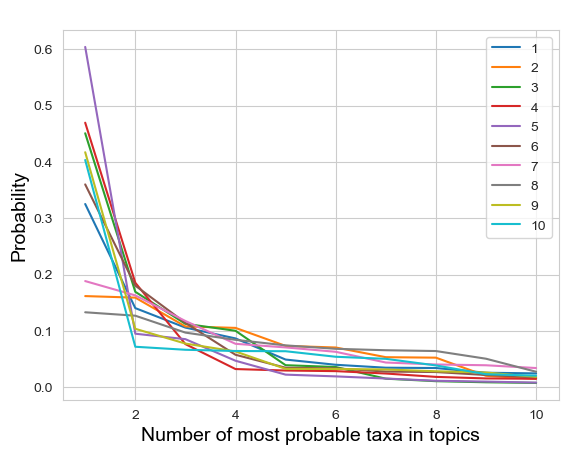

In [7]:
#print top 10 most probable taxa in each topic
print("LDA probabilities")
for i in range(NTOPICS):
    topic_name = 'Topic ' + str(i+1)
    print(topic_name)
    print(df_norm[topic_name].sort_values(ascending = False)[0:10])
    print("----------------------")
    
fig = plt.figure()
for i in range(NTOPICS):
    label = str(i+1)
    topic_name = 'Topic ' + str(i+1)
    sorted_probs = []
    for i, j in df_norm[topic_name].sort_values(ascending = False)[0:10].items():
        sorted_probs.append(j)
    plt.plot(range(1, 11), sorted_probs, label=label)
    
plt.legend()
plt.xlabel('Number of most probable taxa in topics', fontsize=14, color='Black')
plt.ylabel('Probability', fontsize=14, color='Black')
plt.title(" ")
plt.show()

In [8]:
#print top 10 most amplified taxa in each topic
print("Relative amplification")
for i in range(NTOPICS):
    topic_name = 'Topic ' + str(i+1)
    print(topic_name)
    print(s[topic_name].sort_values(ascending = False)[0:10])
    print("----------------------")

Relative amplification
Topic 1
Cyanobacteria_Cyanobacteriia_Chloroplast              0.062258
Firmicutes_Bacilli_Bacillales                         0.053940
Chloroflexi_Anaerolineae_RBG-13-54-9                  0.045659
Proteobacteria_Gammaproteobacteria_Ga0077536          0.044783
Bdellovibrionota_Oligoflexia_Silvanigrellales         0.044090
Chloroflexi_TK10_NA29                                 0.037608
Proteobacteria_Alphaproteobacteria_Tistrellales       0.035843
Cyanobacteria_Cyanobacteriia_Cyanobacteriales         0.035702
Acidobacteriota_Blastocatellia_Blastocatellales       0.034861
Proteobacteria_Gammaproteobacteria_Cellvibrionales    0.031290
Name: Topic 1, dtype: float64
----------------------
Topic 2
Proteobacteria_Gammaproteobacteria_Steroidobacterales        0.048708
Myxococcota_Polyangia_Nannocystales                          0.046691
Acidobacteriota_Thermoanaerobaculia_Thermoanaerobaculales    0.045949
Proteobacteria_Alphaproteobacteria_Azospirillales            0.04359

Text(0.5, 0, 'Topic')

Text(0, 0.5, 'Abundance')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '5'),
  Text(1, 0, '6'),
  Text(2, 0, '8'),
  Text(3, 0, '4'),
  Text(4, 0, '3'),
  Text(5, 0, '9'),
  Text(6, 0, '7'),
  Text(7, 0, '1'),
  Text(8, 0, '10'),
  Text(9, 0, '2')])

(-10.0, 10.0)

(0.0, 10.0)

Text(-5.602669590239257, 5.7, '2')

Text(-3.4201420206072903, 5.7, '3')

Text(-0.42685502743308845, 5.7, '6')

Text(-3.9228809872908315, 5.7, '8')

Text(5.248297823731928, 5.7, '1')

Text(5.824084340561755, 5.7, '4')

Text(6.49179270081401, 5.7, '5')

Text(9.25614448471764, 5.7, '7')

Text(10.341443643445132, 5.7, '9')

Text(7.851210194249273, 5.7, '10')

Text(-10.1, 5, 'G0')

Text(10.1, 5, 'G1')

(-10.0, 10.0, 0.0, 10.0)

(-10.0, 10.0)

(0.0, 10.0)

Text(-10.1, 5, 'G0')

Text(10.1, 5, 'G1')

(-10.0, 10.0, 0.0, 10.0)

(-10.0, 10.0)

(0.0, 10.0)

Text(-2.857476192341341, 5.7, '2')

Text(-0.2676797055427036, 5.7, '3')

Text(-1.2078252335174975, 5.7, '5')

Text(-4.372871212793514, 5.7, '6')

Text(-5.2361681333263554, 5.7, '7')

Text(0.7734799735182707, 5.7, '9')

Text(9.182595807794296, 5.7, '1')

Text(9.59174347643218, 5.7, '4')

Text(9.557055559633021, 5.7, '8')

Text(11.00001768180143, 5.7, '10')

Text(-10.1, 5, 'Half')

Text(10.1, 5, 'Full')

(-10.0, 10.0, 0.0, 10.0)

(-10.0, 10.0)

(0.0, 10.0)

Text(-10.1, 5, 'Half')

Text(10.1, 5, 'Full')

(-10.0, 10.0, 0.0, 10.0)

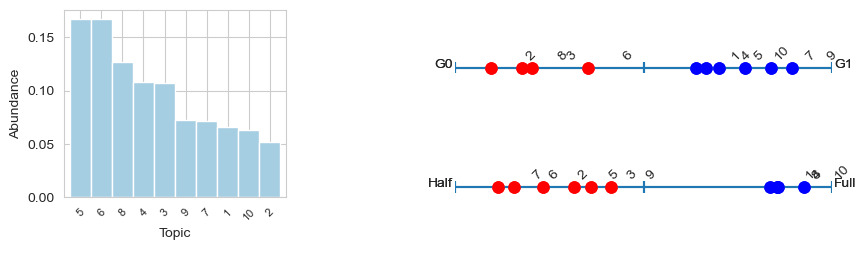

Text(-0.8002669590239256, -0.5257476192341342, '2')

Text(-0.5820142020607291, -0.2667679705542704, '3')

Text(-0.28268550274330884, -0.6772871212793514, '6')

Text(-0.6322880987290831, 0.7157055559633022, '8')

Text(0.2848297823731928, 0.6782595807794297, '1')

Text(0.3424084340561755, 0.719174347643218, '4')

Text(0.409179270081401, -0.36078252335174976, '5')

Text(0.6856144484717639, -0.7636168133326355, '7')

Text(0.7941443643445132, -0.16265200264817292, '9')

Text(0.5451210194249273, 0.860001768180143, '10')

Text(0.5, 0, 'Generation: 0 vs 1')

Text(0, 0.5, 'Watering: Half vs Full')

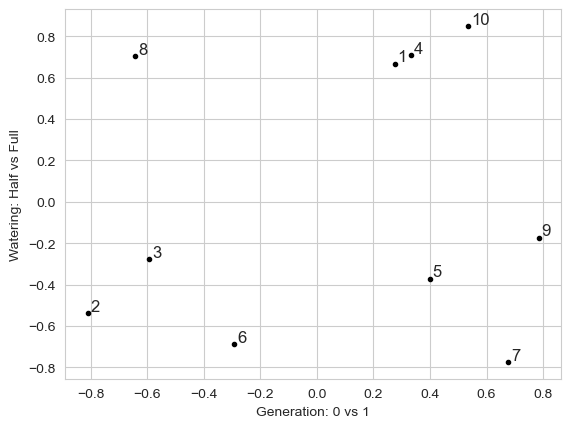

In [9]:
if tax_level == "Sequence":
    path = '../gitlab/data/5cv_all_sequence'
    sub_data = pd.read_csv(path + '/doc-topic_' + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
    sub_data.columns = [str(i) for i in range(1, NTOPICS+1)] 
    source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["Generation"]), pd.DataFrame(df_gen0_gen1["Watering"])], axis=1)
    source_gen = source_gen.sort_index()
    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Watering']

    fig = plt.figure()
    ax3 = plt.subplot2grid((10, 10), (0, 0),colspan=3, rowspan=8)
    test = sub_data
    test.columns = [str(i) for i in range(1, NTOPICS+1)] 
    test = pd.DataFrame(test.mean(axis=0))
    test.columns = ['Topic']
    test = test.sort_values('Topic',ascending=False)
    test = test.plot.bar(stacked=False, width = 1, ax=ax3, color=plt.cm.Paired(np.arange(len(df.T))), rot=0, legend=False)
    plt.xlabel('Topic')
    plt.ylabel('Abundance') 
    plt.xticks(rotation=45, fontsize=4)
    
    ax1 = plt.subplot2grid((10, 10), (0, 5), colspan=5, rowspan=5)
    w0 = potsvstopics[potsvstopics['Generation'] == 0]
    del w0['Generation']
    w1 = potsvstopics[potsvstopics['Generation'] == 1]
    del w1['Generation']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['G0', 'G1']
    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T
    #wt_df
    gwt_df = wt_df

    w_h = []
    w_f = []
    w_hi = []
    w_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['G0'][i] - wt_df['G1'][i]) < 1e-10):
            w_f.append(1 - wt_df['G0'][i]/wt_df['G1'][i])
            w_fi.append(wt_df.index[i])
        else:
            w_h.append(wt_df['G1'][i]/wt_df['G0'][i] - 1)
            w_hi.append(wt_df.index[i])


    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Generation']
    potsvstopics.columns = [str(i) for i in range(1, NTOPICS+1)] + ['Watering']#topic_names+['Watering']

    w0 = potsvstopics[potsvstopics['Watering'] == 0]
    del w0['Watering']
    w1 = potsvstopics[potsvstopics['Watering'] == 1]
    del w1['Watering']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['Half', 'Full']

    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T

    tw_h = []
    tw_f = []
    tw_hi = []
    tw_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['Half'][i] - wt_df['Full'][i]) < 1e-10):
            tw_f.append(1 - wt_df['Half'][i]/wt_df['Full'][i])
            tw_fi.append(wt_df.index[i])
        else:
            tw_h.append(wt_df['Full'][i]/wt_df['Half'][i] - 1)
            tw_hi.append(wt_df.index[i])

    sp_ = pd.DataFrame(
        {'Topic': w_hi + w_fi,
         'Generation': w_h + w_f
        })

    tr_ = pd.DataFrame(
        {'Topic': tw_hi + tw_fi,
         'Watering': tw_h + tw_f
        })

    sptr = sp_.merge(tr_, left_on='Topic', right_on='Topic', how = 'left')


    fig, ax = plt.subplots()

    x_c = sptr['Generation']
    y_c = sptr['Watering']
    types = sptr['Topic']

    for i,type in enumerate(types):
        x = x_c[i]
        y = y_c[i]

        if int(type) == 3 or int(type) == 4 or int(type) == 8 or int(type) == 12 or int(type) == 21 or int(type) == 22:
            plt.scatter(x, y, marker='s', color='black', s = 10)
        if int(type) == 1 or int(type) == 15 or int(type) == 18 or int(type) == 19 or int(type) == 23 or int(type) == 24 or int(type) == 25:
            plt.scatter(x, y, marker='>', color='black', s = 10)
        else:
            plt.scatter(x, y, marker='.', color='black', s = 10)

        #G1, FW   
        if int(type) == 2:
            plt.text(x-0.02, y-0.12, type, fontsize=12, color = 'blue')
        elif int(type) == 4:
            plt.text(x+0.05, y-0.05, type, fontsize=12, color = 'red')
        elif int(type) == 6:
            plt.text(x+0.03, y-0.05, type, fontsize=12, color = 'green')    
        elif int(type) == 16:
            plt.text(x+0.03, y-0.05, type, fontsize=12, color = 'blue')
        elif int(type) == 21:
            plt.text(x-0.05, y+0.05, type, fontsize=12, color = 'green')
        elif int(type) == 19:
            plt.text(x+0.01, y, type, fontsize=12, color = 'red')
        elif int(type) == 23:
            plt.text(x+0.02, y+0.05, type, fontsize=12, color = 'green')
        #G1, HW    
        elif int(type) == 20:
            plt.text(x+0.02, y+0.05, type, fontsize=12, color = 'green')  
        elif int(type) == 18:
            plt.text(x-0.09, y-0.06, type, fontsize=12, color = 'blue')  
        elif int(type) == 12:
            plt.text(x-0.06, y+0.05, type, fontsize=12, color = 'red')  
        elif int(type) == 3:
            plt.text(x+0.02, y-0.01, type, fontsize=12, color = 'red')  
        elif int(type) == 1:
            plt.text(x+0.02, y-0.05, type, fontsize=12, color = 'red')
        #all other
        elif int(type) == 7:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 14:
            plt.text(x, y, type, fontsize=12, color = 'red')
        elif int(type) == 22:
            plt.text(x+0.02, y, type, fontsize=12, color = 'black')
        elif int(type) == 15:
            plt.text(x, y, type, fontsize=12, color = 'red')
        elif int(type) == 8:
            plt.text(x+0.02, y, type, fontsize=12, color = 'blue')
        elif int(type) == 10:
            plt.text(x, y, type, fontsize=12, color = 'black')
        elif int(type) == 24:
            plt.text(x, y, type, fontsize=12, color = 'red')
        elif int(type) == 25:
            plt.text(x, y, type, fontsize=12, color = 'black')
        elif int(type) == 11:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 5:
            plt.text(x, y, type, fontsize=12, color = 'blue')
        elif int(type) == 13:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 17:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 9:
            plt.text(x, y, type, fontsize=12, color = 'red')


    legend_elements1 = [Line2D([0], [0], marker='s', color = 'white', label='Stable', markersize=8, markerfacecolor='black'),
                       Line2D([0], [0], marker='>', color = 'white', label='Switched',
                               markerfacecolor='black', markersize=8),
                        Line2D([0], [0], marker='.', color = 'white', label='No association',
                               markerfacecolor='black', markersize=12)]

    legend_elements2 = [Line2D([0], [0], color = 'red', label='Agriculture',
                              markerfacecolor='black', markersize=10),
                       Line2D([0], [0], color = 'green', label='Forest',
                              markerfacecolor='black', markersize=10),
                       Line2D([0], [0], color = 'blue', label='No inoculation',
                              markerfacecolor='black', markersize=10),
                       Line2D([0], [0], color = 'black', label='No association',
                              markerfacecolor='black', markersize=10)]

    leg1 = ax.legend(handles=legend_elements1, loc = 'center left', bbox_to_anchor = (1.02, 0.87), ncol = 1, title = 'Topic Watering Stability Associations')
    leg2 = ax.legend(handles=legend_elements2, loc = 'center left', bbox_to_anchor = (1.02, 0.5), ncol = 1, title = 'Topic Soil Inoculation Associations')
    ax.add_artist(leg1)

    plt.xlabel('Generation: 0 vs 1', fontsize = 14);
    plt.ylabel('Watering: Half vs Full', fontsize = 14);
    #plt.savefig('./upd_images/seq_1.eps', format='eps', bbox_inches='tight')
    plt.show();
    
else:
    sub_data = pd.read_csv(path + '/doc-topic_' + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
    sub_data.columns = [str(i) for i in range(1, NTOPICS+1)] #topic_names
    source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["Generation"]), pd.DataFrame(df_gen0_gen1["Watering"])], axis=1)
    source_gen = source_gen.sort_index()
    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Watering']


    fig = plt.figure()
    ax3 = plt.subplot2grid((10, 10), (0, 0),colspan=3, rowspan=8)
    test = sub_data
    test.columns = [str(i) for i in range(1, NTOPICS+1)] 
    test = pd.DataFrame(test.mean(axis=0))
    test.columns = ['Topic']
    test = test.sort_values('Topic',ascending=False)
    test = test.plot.bar(stacked=False, width = 1, ax=ax3, color=plt.cm.Paired(np.arange(len(df.T))), rot=0, legend=False)
    plt.xlabel('Topic')
    plt.ylabel('Abundance') 
    plt.xticks(rotation=45, fontsize=8)

    
    ax1 = plt.subplot2grid((10, 10), (0, 5), colspan=5, rowspan=5)
    w0 = potsvstopics[potsvstopics['Generation'] == 0]
    del w0['Generation']
    w1 = potsvstopics[potsvstopics['Generation'] == 1]
    del w1['Generation']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['G0', 'G1']
    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T
    gwt_df = wt_df

    w_h = []
    w_f = []
    w_hi = []
    w_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['G0'][i] - wt_df['G1'][i]) < 1e-10):
            w_f.append(1 - wt_df['G0'][i]/wt_df['G1'][i])
            w_fi.append(wt_df.index[i])
        else:
            w_h.append(wt_df['G1'][i]/wt_df['G0'][i] - 1)
            w_hi.append(wt_df.index[i])


    ax1.set_xlim(-10,10)
    ax1.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax1.hlines(y, xmin, xmax)
    ax1.vlines(xmin, y - height / 2., y + height / 2.)
    ax1.vlines(xmax, y - height / 2., y + height / 2.)

    ax1.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(w_h)):
        ax1.plot(w_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(w_f)):
        ax1.plot(w_f[i]*10, y, 'bo', ms = 8, mfc = 'b')


    for i in range(len(w_hi)):
        ax1.annotate(w_hi[i], (w_h[i]*10,y), xytext = (w_h[i]*10 + 2.5, y + 0.7),  
                  rotation = 45, ha="right")


    for i in range(len(w_fi)):   
        ax1.annotate(w_fi[i], (w_f[i]*10,y), xytext = (w_f[i]*10 + 2.5, y + 0.7),  
                      rotation = 45, ha="right")


    ax1.text(xmin - 0.1, y, 'G0', horizontalalignment='right')
    ax1.text(xmax + 0.1, y, 'G1', horizontalalignment='left')
    ax1.axis('off')      

    ax1.set_xlim(-10,10)
    ax1.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax1.hlines(y, xmin, xmax)
    ax1.vlines(xmin, y - height / 2., y + height / 2.)
    ax1.vlines(xmax, y - height / 2., y + height / 2.)

    ax1.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(w_h)):
        ax1.plot(w_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(w_f)):
        ax1.plot(w_f[i]*10, y, 'bo', ms = 8, mfc = 'b')

    ax1.text(xmin - 0.1, y, 'G0', horizontalalignment='right')
    ax1.text(xmax + 0.1, y, 'G1', horizontalalignment='left')
    ax1.axis('off')



    ax2 = plt.subplot2grid((10, 10), (5, 5), colspan=5, rowspan=5)
    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Generation']
    potsvstopics.columns = [str(i) for i in range(1, NTOPICS+1)] + ['Watering']#topic_names+['Watering']

    w0 = potsvstopics[potsvstopics['Watering'] == 0]
    del w0['Watering']
    w1 = potsvstopics[potsvstopics['Watering'] == 1]
    del w1['Watering']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['Half', 'Full']

    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T

    tw_h = []
    tw_f = []
    tw_hi = []
    tw_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['Half'][i] - wt_df['Full'][i]) < 1e-10):
            tw_f.append(1 - wt_df['Half'][i]/wt_df['Full'][i])
            tw_fi.append(wt_df.index[i])
        else:
            tw_h.append(wt_df['Full'][i]/wt_df['Half'][i] - 1)
            tw_hi.append(wt_df.index[i])


    ax2.set_xlim(-10,10)
    ax2.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax2.hlines(y, xmin, xmax)
    ax2.vlines(xmin, y - height / 2., y + height / 2.)
    ax2.vlines(xmax, y - height / 2., y + height / 2.)

    ax2.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(tw_h)):
        ax2.plot(tw_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(tw_f)):
        ax2.plot(tw_f[i]*10, y, 'bo', ms = 8, mfc = 'b')


    for i in range(len(tw_hi)):
        ax2.annotate(tw_hi[i], (tw_h[i]*10,y), xytext = (tw_h[i]*10 + 2.5, y + 0.7),  
                  rotation = 45, ha="right")

    for i in range(len(tw_fi)):   
        ax2.annotate(tw_fi[i], (tw_f[i]*10,y), xytext = (tw_f[i]*10 + 2.5, y + 0.7),  
                      rotation = 45, ha="right")


    ax2.text(xmin - 0.1, y, 'Half', horizontalalignment='right')
    ax2.text(xmax + 0.1, y, 'Full', horizontalalignment='left')
    ax2.axis('off')      

    ax2.set_xlim(-10,10)
    ax2.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax2.hlines(y, xmin, xmax)
    ax2.vlines(xmin, y - height / 2., y + height / 2.)
    ax2.vlines(xmax, y - height / 2., y + height / 2.)

    ax2.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(tw_h)):
        ax2.plot(tw_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(tw_f)):
        ax2.plot(tw_f[i]*10, y, 'bo', ms = 8, mfc = 'b')



    ax2.text(xmin - 0.1, y, 'Half', horizontalalignment='right')
    ax2.text(xmax + 0.1, y, 'Full', horizontalalignment='left')
    ax2.axis('off')

    fig.tight_layout()
    plt.subplots_adjust(top=0.6, left=-0.3)
    plt.show();


    sp_ = pd.DataFrame(
        {'Topic': w_hi + w_fi,
         'Generation': w_h + w_f
        })

    tr_ = pd.DataFrame(
        {'Topic': tw_hi + tw_fi,
         'Watering': tw_h + tw_f
        })

    sptr = sp_.merge(tr_, left_on='Topic', right_on='Topic', how = 'left')


    x_c = sptr['Generation']
    y_c = sptr['Watering']
    types = sptr['Topic']
    for i,type in enumerate(types):
        x = x_c[i]
        y = y_c[i]
        plt.scatter(x, y, marker='.', color='black')
        plt.text(x+0.01, y+0.01, type, fontsize=12)

    plt.xlabel('Generation: 0 vs 1');
    plt.ylabel('Watering: Half vs Full');
    #plt.savefig('./upd_images/plot_2d_' + str(tax_level) + '.eps', format='eps', bbox_inches='tight')
    plt.show();

In [10]:
#ternary plots, association with soil type and stability of water treatment
sub_data = pd.read_csv(path + '/doc-topic_' + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
sub_data.columns = topic_names
source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["SoilSource"]), pd.DataFrame(df_gen0_gen1["WateringStability"])], axis=1)
source_gen = source_gen.sort_index()
potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
del potsvstopics['ID']
del potsvstopics['WateringStability']


s0 = potsvstopics[potsvstopics['SoilSource'] == 0]
del s0['SoilSource']
s1 = potsvstopics[potsvstopics['SoilSource'] == 1]
del s1['SoilSource']
s2 = potsvstopics[potsvstopics['SoilSource'] == 2]
del s2['SoilSource']


st_df = pd.concat([pd.DataFrame(s0.sum(axis = 0)/np.sum(s0.sum(axis = 0))), pd.DataFrame(s1.sum(axis = 0)/np.sum(s1.sum(axis = 0))), pd.DataFrame(s2.sum(axis = 0)/np.sum(s2.sum(axis = 0)))], axis = 1)
st_df.columns = ['AG', 'FR', 'None'] 
t = st_df.T
t = t.div(t.sum())
t = t.T
c = t

c.loc[:, 'None'].sort_values(ascending = False)

sns.set_style("whitegrid")
c['Topic'] = range(1,NTOPICS+1)
c.columns = ['AG', 'FR', 'None', 'Topic']
color_discrete_map={"CustomColor": 'red'}
fig = px.scatter_ternary(c, a="AG", b="FR", c="None", size_max=15, text="Topic")#, color="Abundance", color_continuous_scale='RdYlBu_r')#, title = "Colored by the topic abundance")
fig = fig.update(layout=dict(title=dict(x=0.5)))
fig = fig.update_coloraxes(colorbar_title_side="bottom")
fig = fig.update_traces(textposition='bottom center', textfont=dict(size=12), selector=dict(type='scatterternary'), marker=dict(color='lightblue'))
#fig.write_image("./upd_images/plot_ternary_" + str(tax_level) + '.eps')
fig.show()



sub_data = pd.read_csv(path + "/doc-topic_" + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
sub_data.columns = topic_names
source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["SoilSource"]), pd.DataFrame(df_gen0_gen1["WateringStability"])], axis=1)
source_gen = source_gen.sort_index()
potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
del potsvstopics['ID']
del potsvstopics['SoilSource']


ws0 = potsvstopics[potsvstopics['WateringStability'] == 0]
del ws0['WateringStability']
ws1 = potsvstopics[potsvstopics['WateringStability'] == 1]
del ws1['WateringStability']
ws2 = potsvstopics[potsvstopics['WateringStability'] == 2]
del ws2['WateringStability']


ws_df = pd.concat([pd.DataFrame(ws0.sum(axis = 0)/np.sum(ws0.sum(axis = 0))), pd.DataFrame(ws1.sum(axis = 0)/np.sum(ws1.sum(axis = 0))), pd.DataFrame(ws2.sum(axis = 0)/np.sum(ws2.sum(axis = 0)))], axis = 1)
ws_df.columns = ['Gen 0', 'Stable', 'Switched']


t = ws_df.T
t = t.div(t.sum())
t = t.T
c = t

c.loc[:, 'Gen 0'].sort_values(ascending = False)
c.loc[:, 'Stable'].sort_values(ascending = False)
c.loc[:, 'Switched'].sort_values(ascending = False)

sns.set_style("whitegrid")   
c['Topic'] = range(1, NTOPICS + 1)
c.columns = ["G0", "ST", "SW", 'Topic']
color_discrete_map={"CustomColor": 'red'}
#fig = plt.subplots(figsize=(10,10))
fig = px.scatter_ternary(c, a="G0", b="ST", c="SW", size_max=15, text="Topic")#, color="Abundance", color_continuous_scale='RdYlBu_r')#, title = "Colored by the topic abundance")
fig = fig.update(layout=dict(title=dict(x=0.5)))
fig = fig.update_coloraxes(colorbar_title_side="bottom")
fig = fig.update_traces(textposition='bottom center', textfont_size=12, selector=dict(type='scatterternary'), marker=dict(color='lightblue'))
#fig.write_image("./upd_images/plot_ternary2_" + str(tax_level) + '.eps')
fig.show()


Topic 4     0.567340
Topic 2     0.506570
Topic 9     0.490624
Topic 5     0.350503
Topic 6     0.326553
Topic 1     0.241389
Topic 3     0.217444
Topic 10    0.217075
Topic 8     0.144624
Topic 7     0.010556
Name: None, dtype: float64

Topic 2     0.724918
Topic 8     0.582946
Topic 3     0.550669
Topic 6     0.414142
Topic 1     0.266101
Topic 4     0.250260
Topic 5     0.231012
Topic 10    0.188601
Topic 7     0.139558
Topic 9     0.097414
Name: Gen 0, dtype: float64

Topic 7     0.590862
Topic 10    0.571713
Topic 4     0.429793
Topic 5     0.380147
Topic 1     0.315758
Topic 9     0.289293
Topic 6     0.252422
Topic 8     0.228171
Topic 3     0.150060
Topic 2     0.107437
Name: Stable, dtype: float64

Topic 9     0.613293
Topic 1     0.418141
Topic 5     0.388841
Topic 6     0.333435
Topic 4     0.319947
Topic 3     0.299271
Topic 7     0.269581
Topic 10    0.239686
Topic 8     0.188883
Topic 2     0.167644
Name: Switched, dtype: float64

In [12]:
#Spearman's rank correlation with plant traits
ntopics = NTOPICS
response_list = ['WUEi', "Amax", 'Cond', 'SCP_Curve', 'Stem_Diam', 'DroughtTime', 'RootDry_g', "Height_cm", "LWC", "LMA"]
store_cor = []
store_pval = []
topic_list = topic_names
alpha = 0.05

if tax_level == 'Sequence':
    sub_data = pd.read_csv('../gitlab/data/5cv_all_sequence' + "/doc-topic_" + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
    sub_data.columns = topic_names
    for i in response_list:
        store_cor.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[0])
        store_pval.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[1])

    store_pval = [item for sublist in store_pval for item in sublist]
    store_cor = [item for sublist in store_cor for item in sublist]
    store_names = [item for item in response_list for i in range(ntopics)]
    store_topics = topic_list*len(response_list)
    df_p = pd.DataFrame(
        {'topic': store_topics,
         'response': store_names,   
         'correlation': store_cor,
         'p-value': store_pval
        })
    cor_alpha = len(df_p.sort_values("p-value"))
    df_p = df_p.sort_values("p-value", ascending=True).reset_index()
    save_ix = []
    for i in range(len(df_p)):
        if (df_p['p-value'][i] <= alpha/cor_alpha):
            cor_alpha -= 1
            save_ix.append(df_p.index[i])
    df_p = df_p.iloc[save_ix, 1:5]
    print(df_p.to_latex(index=False))  
else:
    for i in response_list:
        store_cor.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[0])
        store_pval.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[1])
    store_pval = [item for sublist in store_pval for item in sublist]
    store_cor = [item for sublist in store_cor for item in sublist]
    store_names = [item for item in response_list for i in range(ntopics)]
    store_topics = topic_list*len(response_list)
    df_p = pd.DataFrame(
        {'topic': store_topics,
         'response': store_names,   
         'correlation': store_cor,
         'p-value': store_pval
        })
    cor_alpha = len(df_p.sort_values("p-value"))
    df_p = df_p.sort_values("p-value", ascending=True).reset_index()
    save_ix = []
    for i in range(len(df_p)):
        if (df_p['p-value'][i] <= alpha/cor_alpha):
            cor_alpha -= 1
            #print(i, alpha/cor_alpha, df_p['topic'][i], df_p['response'][i], df_p['correlation'][i], df_p['p-value'][i])
            save_ix.append(df_p.index[i])

    df_p = df_p.iloc[save_ix, 1:5]
    print(df_p.to_latex(index=False))  



\begin{tabular}{llrr}
\toprule
  topic &  response &  correlation &      p-value \\
\midrule
Topic 9 & Height\_cm &     0.467979 & 8.025462e-08 \\
Topic 2 & Height\_cm &    -0.442553 & 4.668667e-07 \\
Topic 3 & RootDry\_g &     0.399039 & 6.949396e-06 \\
Topic 4 &       LMA &    -0.377003 & 2.376296e-05 \\
Topic 6 &       LMA &     0.361012 & 5.495218e-05 \\
Topic 9 & RootDry\_g &    -0.354309 & 7.708443e-05 \\
Topic 3 & Height\_cm &    -0.352856 & 8.286636e-05 \\
Topic 3 & Stem\_Diam &     0.341337 & 1.452856e-04 \\
Topic 8 & Height\_cm &    -0.330276 & 2.441251e-04 \\
Topic 2 & RootDry\_g &     0.319484 & 3.976095e-04 \\
\bottomrule
\end{tabular}

